# Biased upsampling of TF-distance dependent activations from mixtures

In this simulation, we define a mixture as a fraction of activations drawn from a TF distance-based activation function (which we call "_positives_"), and a fraction of activations drawn from a distribution resembling "no activation" (which we call "_negatives_"). For the latter we use a lognormal distribution with $\sigma=1$ and $\mu=0$ (i.e., parameters `s`=$\sigma$ and `scale`=$e^\mu$ for `scipy.stats.lognormal`).

As we have found, when the fraction of positives in the mixture drops towards 1-2%, the model training fails to recover the distance-dependent activation function of the positives.

Here we explore whether and to what extent probabilistic biased sampling can increase the fraction of positives. The rationale is that the fraction of positives in experimental data is likely small, and possibly in the range of 1-2%, raising the question whether biased sampling can make increase their frequency to a level that we know suffices for the model training to recover the pattern of their activation function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

## TF distance-dependent activation function

In [2]:
def activation_score(dist, peak_dist=200, score_ceiling=200, offset=0, log_scale=False):
    score = np.fmin(np.abs(peak_dist - dist), score_ceiling)
    if log_scale:
        score = np.log2(np.fmax(score, 1))
        if offset != 0:
            offset = np.log2(np.abs(offset)) * np.sign(offset)
    return score + offset

## Sampling a mixture of positives and negatives

We create a function that samples a mixture of positives and negatives, where the fraction of positives is given by `posfrac`. The positives are drawn from the TF distance-dependent activation function, and the negatives are drawn from a lognormal distribution with parameters $\sigma=1$ and $\mu=0$.

The function returns a 2-dimensional array of shape `(size, 2)`, where `size` is the number of samples. The first column contains the scores (from positives and negatives), and the second column contains the TF distance for positives, and NaN for negatives. This allows tracking the distribution of TF distances before and after biased sampling, and to asses how many positves are retained in the biased sample.

In [3]:
def sample_scores(size=100_000, posfrac=0.01,
                  min_TFdist=10, TFlen=10, seqlen=300, **score_func_kwargs):
    neg_scores = lognorm.rvs(s=1, scale=1, size=int(size * (1-posfrac)))
    dists = np.random.randint(min_TFdist, seqlen-TFlen-min_TFdist, size=int(size * posfrac))
    pos_scores = np.column_stack((activation_score(dists, **score_func_kwargs), dists))
    neg_scores = np.column_stack((neg_scores, np.full(neg_scores.shape, np.nan)))
    scores = np.concatenate([neg_scores,pos_scores])
    np.random.shuffle(scores)
    return scores


## Score-dependent acceptance probability functions

We compare a few different acceptance probability functions that all depend only on the score of the sample. The acceptance probability is the probability that a sample is accepted during sampling.

The implementation of biased downsampling in BlueSTARR uses histogram densities (in essence an empirical PDF). We want to reimplement this and have as comparison an empirical CDF. KDE implementations in Scipy, Scikit-learn, and Statsmodels don't seem to provide a built-in CDFs for KDEs, so are implementing a class that does both, and can interpolate the PDF and CDF or not. (The BlueSTARR implementation does not use interpolation, and is thus a step function.)

In [4]:
from scipy.stats import gaussian_kde
from scipy.interpolate import PchipInterpolator
from scipy.stats import expon

In [5]:
class HistKDE:
    def __init__(self, samples, bins=1000):
        (densities, bin_edges) = np.histogram(samples, bins=bins, density=True)
        self.bins = bin_edges
        self.mids = bin_edges[1:] - np.diff(bin_edges)/2
        self.probs = densities * np.diff(bin_edges)
        self.cum_probs = np.cumsum(self.probs)
        self.interp_pdf = PchipInterpolator(self.mids, self.probs, extrapolate=True)
        self.interp_cdf = PchipInterpolator(self.mids, self.cum_probs, extrapolate=True)

    def __call__(self, x):
        return self.pdf(x)

    def pdf(self, x, interpolate=True):
        if interpolate:
            return self.interp_pdf(x)
        else:
            bin_indices = np.digitize(x, self.bins[1:], right=False).clip(0, len(self.probs)-1)
            return self.probs[bin_indices]

    def cdf(self, x, interpolate=True):
        if interpolate:
            return self.interp_cdf(x)
        else:
            bin_indices = np.digitize(x, self.bins[1:], right=False).clip(0, len(self.cum_probs)-1)
            return self.cum_probs[bin_indices]

Define acceptance probability functions based on empirical PDF and CDF, and on a distribution-based CDF.

In [6]:
def scores_and_unif(scores: np.ndarray):
    if scores.ndim > 1:
        scores = scores[:,0]
    (min, max) = (int(scores.min()), int(scores.max()))
    unif = (1 / (max - min + 1))
    return scores, unif

def accept_hist_pdf(scores, kde=None, hist_bins=1000, interpolate=True):
    scores, _ = scores_and_unif(scores)
    if not kde:
        kde = HistKDE(scores, bins=hist_bins)
    return 1 - kde.pdf(scores, interpolate=interpolate)

def accept_hist_cdf(scores, kde=None, hist_bins=1000, interpolate=True):
    scores, _ = scores_and_unif(scores)
    if not kde:
        kde = HistKDE(scores, bins=hist_bins)
    return kde.cdf(scores, interpolate=interpolate)

def accept_cdf(scores, distclass=lognorm, postfunc=lambda x: x, **cdf_params):
    scores, _ = scores_and_unif(scores)
    return postfunc(distclass.cdf(scores, **cdf_params))


## Mixture sample and histogram

We need to create a large enough sample that even with a low fraction of positives (e.g., 1-2%) we can still have a good sampling across the range of TF distances, and for simulated sequences, the TF positions along the sequences. This suggests that we need to have at least around 10,000 positives in the sample.

If we want biased downsampling to not resample (and thus duplicate) the same positives (or, for that matter, negatives), and want to increase the fraction of positives by up to 10x (e.g., from 1% to 10%), we need to be able to downsample to 10% of the starting sample size, or even 1%.

This suggests that we need to have at least around 1,000,000 samples in the starting pool.

In [7]:
scores_sample = sample_scores(size=1_000_000)

Text(0.5, 1.0, 'Histogram of sampled activation scores')

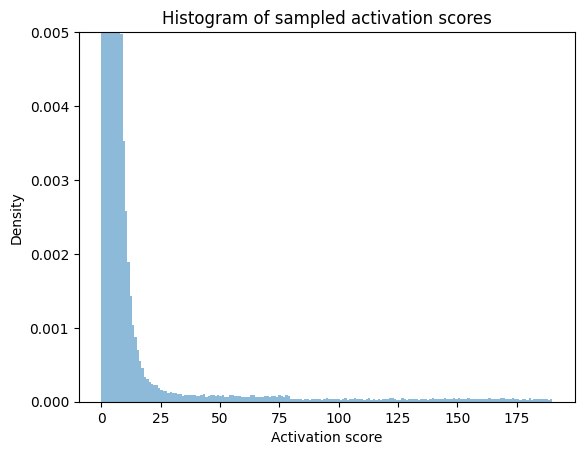

In [8]:
nbins = int(np.max(scores_sample[:,0])-np.min(scores_sample[:,0])+1)
hist = plt.hist(scores_sample[:,0], bins=nbins, density=True, alpha=0.5)
plt.ylim(top=0.005)
plt.xlabel("Activation score")
plt.ylabel("Density")
plt.title("Histogram of sampled activation scores")

## Visaualization of different acceptance probability 

We visualize the acceptance probability functions for a very dense linear sampling of the range of scores. This is still two order of magnitude less data than the number of samples in the mixture sample.

In [17]:
scores = np.log2(np.linspace(1, 1024, num=10000, endpoint=True))

The linear sampling isn't suitable for creating a score distribution histogram on the fly, we need to create it in advance from the original mixture sample.

In [18]:
histkde = HistKDE(scores_sample[:,0], bins=200)

Visualize a number of different acceptance probability functions:

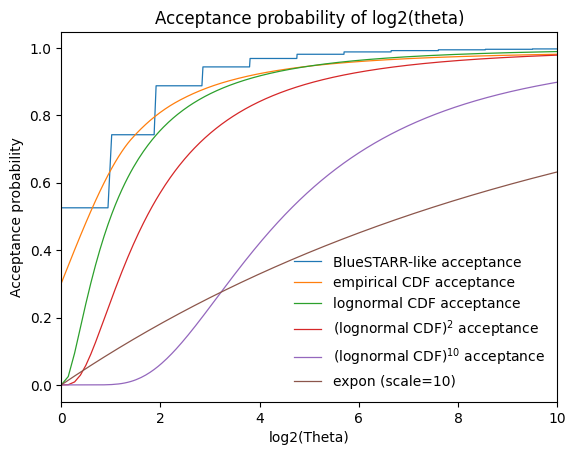

In [35]:
plt.plot(scores, accept_hist_pdf(scores, kde=histkde, interpolate=False),
         linewidth=0.9, label="BlueSTARR-like acceptance")
plt.plot(scores, accept_hist_cdf(scores, kde=histkde, interpolate=True),
         linewidth=0.9, label="empirical CDF acceptance")
plt.plot(scores, accept_cdf(scores, s=1, scale=1),
         linewidth=0.9, label="lognormal CDF acceptance")
plt.plot(scores, accept_cdf(scores, postfunc=np.square, s=1, scale=1),
         linewidth=0.9, label="(lognormal CDF)$^{2}$ acceptance")
plt.plot(scores, accept_cdf(scores, postfunc=lambda x: np.power(x, 10), s=1, scale=1),
         linewidth=0.9, label="(lognormal CDF)$^{10}$ acceptance")
plt.plot(scores, accept_cdf(scores, distclass=expon, scale=10),
         linewidth=0.9, label="expon (scale=10)")
plt.xlim(left=0, right=10)
plt.xlabel("log2(Theta)")
plt.ylabel("Acceptance probability")
plt.title("Acceptance probability of log2(theta)")
plt.legend(frameon=False)

## Performing biased downsampling and assessing the results

Define a function that takes a sample and an acceptance probability function, performs the sampling according to the acceptance probabilities, and returns the resulting (sub)sample.

In [ ]:
def sample_scores_accept(scores, accept_probs, frac=0.1):
    rng = np.random.default_rng()
    accept_probs = accept_probs / accept_probs.sum()
    return rng.choice(scores, size=int(len(scores) * frac), replace=False, p=accept_probs)

Collect results from a number of different acceptance probability functions.

In [ ]:
def downsample(scores_sample, kde=histkde, frac=0.1):
    method_labels = ["BlueSTARR", "ECDF", "lognormal CDF", "(lognormal CDF)$^{2}$", "(lognormal CDF)$^{10}$", "exponential"]
    scores_biased = (
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_hist_pdf(scores_sample, kde=kde, interpolate=False)),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_hist_cdf(scores_sample, kde=kde, interpolate=True)),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, s=1, scale=1)),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, s=1, scale=1, postfunc=np.square)),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, s=1, scale=1, postfunc=lambda x: np.power(x, 10))),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, distclass=expon, scale=1))
    )
    return scores_biased, method_labels

### Histograms of the collected samples

Grouped barcharts for each histogram bin:

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(10)

scores_biased, method_labels = downsample(scores_sample, frac=0.1)

hist = ax.hist([x[:,0] for x in (scores_sample,) + scores_biased], bins=25, density=True, alpha=0.5,
               label=["Unbiased"] + method_labels)
ax.set_ylim(top=0.005)
ax.set_xlabel("Activation score")
ax.set_ylabel("Density")
ax.set_title(f"Histogram of (down)sampled activation scores")
ax.legend()


### Assessing the fraction of positives in the biased samples

In [ ]:
fracs = [0.27]
posfrac = (~np.isnan(scores_sample[:,1])).sum() / len(scores_sample)
print(f"Unbiased sample: {posfrac:.2%} positives")
for frac in fracs:
    scores_biased, method_labels = downsample(scores_sample, frac=frac)
    print(f"Biased downsampling to {frac:.1%}:")
    for sample, method_label in zip(scores_biased, method_labels):
        posfrac = (~np.isnan(sample[:,1])).sum() / len(sample)
        print(f"  {method_label}: {posfrac:.2%} positives")

## Appendix: Comparison of different histogram-based empirical PDF and CDF implementations

In [ ]:
histkde = HistKDE(scores_sample[:,0], bins=200)
gauss_kde = gaussian_kde(histkde.mids, bw_method=0.05, weights=histkde.probs)

In [ ]:
scores = np.linspace(0, scores_sample[:,0].max()+1, 10000)
plt.plot(scores, 1-gauss_kde.pdf(scores), label="1 - Gaussian KDE PDF")
plt.plot(scores, histkde.cdf(scores), label="Histogram CDF (interpolated)")
plt.plot(scores, histkde.cdf(scores, interpolate=False), label="Histogram CDF")
plt.plot(histkde.mids, histkde.cum_probs, label="Histogram cumulative")
plt.xlim(left=-1, right=30)
plt.xlabel("Activation score")
plt.ylabel("Density")
plt.title("Gaussian vs. Histogram KDE (both from 200 bins)")
plt.legend()
